In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
#!git clone https://github.com/gorkamunoz/ANDI.git

In [ ]:
%cd '/content/gdrive/My Drive/Autoencoder Diffusion/ANDI'
!pip install fbm

/content/gdrive/My Drive/Autoencoder Diffusion/ANDI


In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from andi import ANDI
from utils import normalize

In [2]:
import torch
from tqdm import tqdm
#import torchvision as tv
#import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [3]:
timesteps = 1000     #Number of timesteps per trajectory
N_trainset = 300     #Number of trajectories in the training set per model & per exponent
N_testset = 100     #Number of trajectories in the test set per model & per exponent
dimension = 1     #Dimension of trajectories
exponents = [0.8,1,1.2]     #Anomalous exponent. Creates a dataset of size N_trajectories * T_trajectory for each exponent
models = [2]     #Models. In order: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']

In [54]:
learning_rate = 1e-3     #Learning rate
epochs = 30     #Training epochs
batch_size =  10    #Batch size
gpu = True     #Use of GPU

In [5]:
device = torch.device('cuda' if gpu and torch.cuda.is_available() else 'cpu')

In [91]:
anomalous = ANDI()
train_dataset = anomalous.create_dataset(T = timesteps, N = N_trainset, exponents = exponents, models = models, 
                              dimension=dimension, path = 'trajectories/')
test_dataset = anomalous.create_dataset(T = timesteps, N = N_testset, exponents = exponents, models = models, 
                              dimension=dimension, path = 'trajectories/')

In [36]:
def normalize(trajectories):
    normalized_trajectories = (trajectories - np.mean(trajectories, axis=1)[:,np.newaxis]) / np.std(trajectories, axis=1)[:,np.newaxis]
    return normalized_trajectories

In [92]:
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

labels = train_dataset[:,0:2]

trainset = torch.from_numpy(normalize(train_dataset[:,2:])).float().to(device)
testset = torch.from_numpy(normalize(test_dataset[:,2:])).float().to(device)



In [93]:
trainset=trainset.reshape(trainset.shape[0],1,trainset.shape[1])
testset=testset.reshape(testset.shape[0],1,testset.shape[1])

In [44]:
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [24]:
class Autoencoder(nn.Module):
    def __init__(self,decode=True):
        super(Autoencoder,self).__init__()
        self.decode=decode
        self.encoder = nn.Sequential(
            nn.Conv1d(1,12, kernel_size=5),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(12,1,kernel_size=5),
            nn.MaxPool1d(5, stride=2),
            nn.Linear(244,24))
        self.decoder = nn.Sequential(
            nn.Linear(24,992),
            nn.ConvTranspose1d(1,12,kernel_size=5),
            nn.ConvTranspose1d(12,1,kernel_size=5))
    def forward(self,x):
        x = self.encoder(x)
        if self.decode:
          x = self.decoder(x)
        return x

In [57]:
model = Autoencoder().to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5,lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [51]:
model(trainset[0].reshape(1,1,1000)).shape

torch.Size([1, 1, 1000])

In [58]:
loss_evo,loss_test_evo=[],[]
for epoch in range(epochs):

    for data in dataloader:
        img = data
        img = Variable(img).to(device)
        # forward
        output = model(img)
        loss = distance(output, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for test in testloader:
        sample = test
        sample = Variable(sample).to(device)
        out = model(sample)
        loss_test = distance(out, sample)
        
    loss_evo.append(loss.item())
    loss_test_evo.append(loss_test.item())

    #log
    if (epoch+1) % 5 == 0:
      print('epoch [{}/{}], loss:{:.4f}, loss_test:{:.4f}'.format(epoch+1, epochs, loss.item(), loss_test.item()))

epoch [5/30], loss:0.0821, loss_test:0.0497
epoch [10/30], loss:0.0635, loss_test:0.0376
epoch [15/30], loss:0.0592, loss_test:0.0346
epoch [20/30], loss:0.0572, loss_test:0.0333
epoch [25/30], loss:0.0559, loss_test:0.0327
epoch [30/30], loss:0.0548, loss_test:0.0322


Text(0.5, 1.0, 'Training Loss')

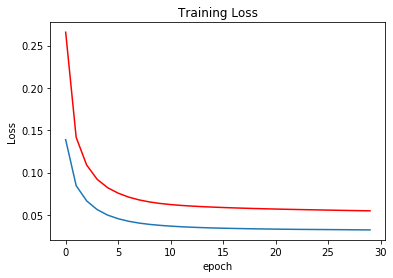

In [64]:
plt.figure
plt.plot(loss_evo, c='r')
plt.plot(loss_test_evo)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

Text(0.5, 1.0, 'Test Loss')

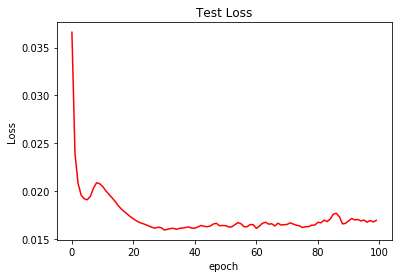

In [ ]:
plt.figure
plt.plot(loss_test_evo, c='r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Test Loss')

ValueError: x and y can be no greater than 2-D, but have shapes (1,) and (1, 1, 24)

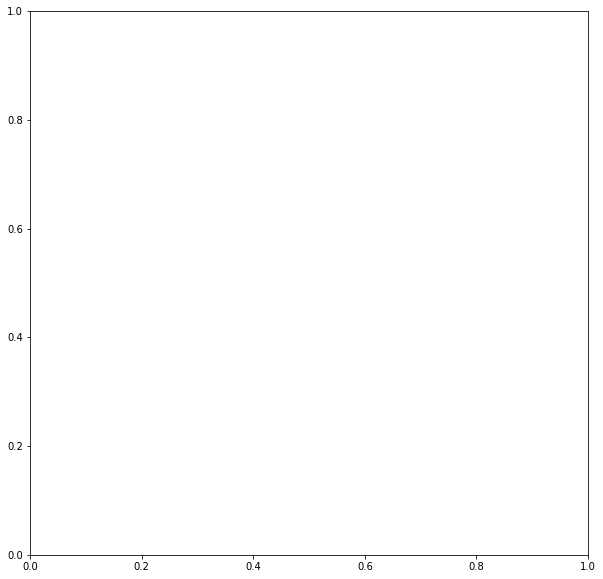

In [101]:
plt.figure(figsize=(10,10))
plt.plot(model(trainset[0].reshape(1,1,1000)).detach().cpu().numpy())
plt.plot(trainset[0].detach().cpu().numpy())
plt.title('Model output vs training data')

Text(0.5, 1.0, 'Model output vs test data')

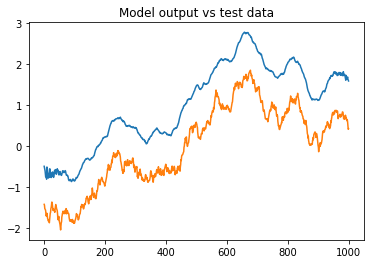

In [ ]:
plt.plot(out[0,0].detach().cpu().numpy()+1)
plt.plot(sample[0,0].detach().cpu().numpy())
plt.title('Model output vs test data')

In [99]:
model.decode=False
# x=[model(img)[0][0].detach().to('cpu').numpy() for img in dataloader]

x = [model(im.reshape(1,1,1000)).detach().to('cpu').numpy() for im in trainset]

x=np.asarray(x).reshape(900, 24)
#x=np.concatenate((labels,x),axis=1)

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
p = pca.fit_transform(x)

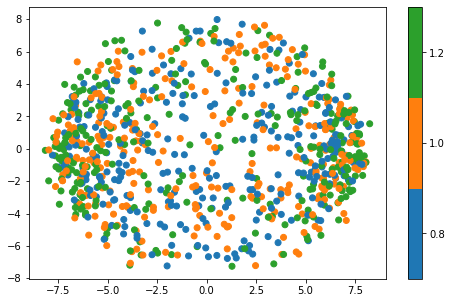

In [97]:
plt.figure(figsize=(8,5))
cmap = matplotlib.colors.ListedColormap(['#1f77b4','#ff7f0e','#2ca02c'])
bounds=[0.7,0.9,1.1,1.3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plt.scatter(p[:, 0], p[:, 1], c=labels[:,1],cmap=cmap,norm=norm)
plt.colorbar(ticks=[0.8,1,1.2])

In [98]:
labels

array([[2. , 0.8],
       [2. , 0.8],
       [2. , 0.8],
       ...,
       [2. , 1.2],
       [2. , 1.2],
       [2. , 1. ]])